# 量子シミュレーション

<Admonition type="note">
  Yukio Kawashima (May 30, 2024)　翻訳：Hotaka Hayashi(2025)

  元の講義の[PDFのダウンロードはこちらから](https://github.com/quantum-tokyo/introduction/tree/main/src/courses/utility-scale-quantum-computing)。 

  *QPU上の推定ランタイム：7秒*
</Admonition>

## 1. イントロダクション

トロッター分解は量子ゲートを応用し、量子系の時間発展を記述する方法として活用されています。これは量子系の時間発展を微小時間ごとに区切り、その区間内での時間発展を近似値として求める方法です。Schrödinger方程式によれば、$\vert\psi(0)\rangle$で初期化された量子系の時間発展は以下のように書けます。：

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

ここで$H$は時間依存のハミルトニアンです。このハミルトニアンをパウリ行列の重み付き和$H=\sum_j a_j P_j$で書けると考えましょう。ここで$P_j$はパウリ行列のテンソル積であり、$n$量子ビットに作用します。特に、テンソル積の各項は、高々2つのパウリ行列を含むものであると仮定しましょう。与えられた$t=0$の初期状態に対する、時間$t$後の量子状態$|\psi(t)\rangle$を、量子コンピュータを用いてどのように得られるでしょうか。ここで、行列の指数関数はテイラー展開を用いて以下のように簡単に表せます。：

$$
e^{-i H t} = 1-iHt-\frac{1}{2}H^2t^2+...
$$

$e^{iZ}$のような簡単な行列指数関数は、量子コンピュータへ簡単に実装することができます。しかし実用上の多くのハミルトニアンは単一項でなく、多くの項を持つものです。ここで$H = H_1+H_2$とすれば以下のようになります。:
$$
e^{-i H t} = 1-i(H_1+H_2)t-\frac{1}{2}(H_1+H_2)^2t^2+...
$$

もし$H_1$と$H_2$が可換ならば、複素数のときのように以下の形を得られます。（以下では変数は$a,b$です）：
$$
e^{-i (a+b) t} = e^{-i a t}e^{-i b t}
$$

しかし演算子が可換でないならば、上記のように扱えず、テイラー展開の各項は簡単に表現することができません。そのため、複雑なハミルトニアンを量子ゲートで表現することは困難な課題です。

これに対する1つの解決策は、微小時間$t$を考え、テイラー展開の1次の項が支配的であるとすることです。この仮定のもとでは、

$$
e^{-i (H_1+H_2) t} \approx 1-i(H_1+H_2)t \approx (1-i H_1 t)(1-i H_2 t) \approx e^{-i H_1 t}e^{-i H_2 t}
$$

もちろん、微小時間ではなく長時間における時間発展を考える必要があるでしょう。そのためには、微小時間のステップを多用すればよいです。これをトロッター分解といいます。

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j P_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

ここで、$t/r$が時間ステップです。そのため、時間$t$の間の時間発展を表現するために、微小時間$t/r$の時間発展を表現するゲートを$r$回適用します。より時間幅を狭くすることで、推定値はより高い精度で得られます。しかしながらこれは量子回路が深くなっていくことにもつながり、実用上より大きなエラーを引き起こしてしまいます。（近年のNISQデバイスでは無視できない影響です。）

今回は、[イジングモデル](https://en.wikipedia.org/wiki/Ising_model)の時間発展について学びましょう。これらの格子は、隣り合うものとのみ相互作用するスピン$\sigma_i$の配列からなります。これらのスピンは2つの向き$\uparrow$, $\downarrow$を持ちます。これは磁化$+1$と$-1$に対応します。

$$
H = - J \sum_{i=0}^{N-2} Z_i Z_{i+1} - h \sum_{i=0}^{N-1} X_i  \text{,}
$$

ここで$J$は相互作用のエネルギーを、$h$は外場の強さを示します（上記ではx方向のものを表しているが、後に角度を変えた別のパターンも示します。）。これをパウリ行列を用いて表現し、外場が横向きに対して角度$\alpha$のときのケースを考えましょう。

$$
H = -J \sum_{i=0}^{N-2} Z_i Z_{i+1} -h \sum_{i=0}^{N-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

このハミルトニアンは、外場の影響を簡単に調べられるため便利です。計算基底としては、この系は以下のように表現されます。

|       量子状態      |             スピン            |
| :----------------------: | :----------------------------------------: |
| $\lvert 0 0 0 0 \rangle$ |     $\uparrow\uparrow\uparrow\uparrow$     |
| $\lvert 1 0 0 0 \rangle$ |    $\downarrow\uparrow\uparrow\uparrow$    |
|         $\ldots$         |                  $\ldots$                  |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

まずは量子系の時間発展について知ることから始めましょう。さらにその1つのケースとして、磁化などの特性の時間発展を可視化してみましょう。



### 1.1 要件

このチュートリアルを始める前に、以下のものがインストールされているか確認してください：

*   v1.2以降のQiskit SDK( `pip install qiskit` )
*   v0.30以降のQiskit Runtime ( `pip install qiskit-ibm-runtime` )
*   v1.24.1以降v2以下のNumpy ( `pip install numpy` )



### 1.2 ライブラリのインポート

MatrixExponential, QDriftなど、このノートブックでは使用しないが有用なライブラリも含まれています。時間があれば、ぜひ使ってみてください！


In [1]:
# Check the version of Qiskit
import qiskit

qiskit.__version__

'2.1.0'

In [2]:
# Import the qiskit library
import numpy as np
import matplotlib.pylab as plt
import warnings

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (
    SuzukiTrotter,
    LieTrotter,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

warnings.filterwarnings("ignore")

## 2. 問題のマッピング

### 2.1 イジングハミルトニアンの磁場の定義

1次元イジングモデルの磁場を考えましょう。

まず、系のパラメータ$N$, $J$, $h$,$\alpha$を引数とし、`SparsePauliOp`としてハミルトニアンを返す関数を定義しましょう。[SparsePauliOp](/docs/api/qiskit/qiskit.quantum_info.SparsePauliOp)は、ハミルトニアンを重み付きの[Pauli](/docs/api/qiskit/qiskit.quantum_info.Pauli)演算子の項によってスパースに表現します。



In [3]:
def get_hamiltonian(nqubits, J, h, alpha):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, nqubits)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list(
        [*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=nqubits
    )
    return hamiltonian.simplify()

#### ハミルトニアンを定義する

例として、$N=6$, $J=0.2$, $h=1.2$, $\alpha=\frac{\pi}{8.0}$の系を考えましょう。


In [4]:
n_qubits = 6

hamiltonian = get_hamiltonian(nqubits=n_qubits, J=0.2, h=1.2, alpha=np.pi / 8.0)
hamiltonian

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j,
 -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j, -1.10865544+0.j,
 -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j,
 -1.10865544+0.j])

### 2.2 時間発展シミュレーションのパラメータ設定

ここでは、以下の3つのトロッター分解の技法を学びましょう。

*   リー・トロッター分解 (1次)
*   2次 鈴木・トロッター分解
* 　4次 鈴木・トロッター分解

後者の2つは例題や付録で登場します。

In [5]:
num_timesteps = 60
evolution_time = 30.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()
product_formula_st2 = SuzukiTrotter(order=2)
product_formula_st4 = SuzukiTrotter(order=4)

### 2.3 量子回路１(初期状態)の準備

初期状態を作成します。$\uparrow\uparrow\downarrow\downarrow\uparrow\uparrow$のスピンから始めましょう。


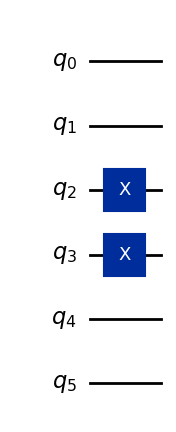

In [6]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state("001100")
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=1).draw("mpl")

### 2.4 量子回路２(時間発展の回路)の準備

リー・トロッター分解の1時間ステップを表す量子回路を作ります。

1次のリー積公式は、[LieTrotter](/docs/api/qiskit/qiskit.synthesis.LieTrotter)クラスで実装されています。1次の公式は、イントロダクションで説明したような、行列の和の指数関数を行列指数関数の積で表すという近似からなります。：

$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$


$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$真

前に述べた通り、深い量子回路はエラーの蓄積を引き起こし、現代の量子コンピュータでの扱いを困難にします。2量子ビットゲートは1量子ビットゲートよりも高いエラー率であるため、特に2量子ビットゲートの深さが興味の対象です。真に注意すべき問題は、トランスパイル後の2量子ビットゲートの深さです（それが、量子コンピュータが実際に処理する量子回路であるため）。今はシミュレーターを用いているとはいえ、回路の操作の数を数えることを習慣づけましょう。


Trotter step with Lie-Trotter
-----------------------------
Depth: 17
Gate count: 27
Nonlocal gate count: 10
Gate breakdown: U: 12, CX: 10, P: 5



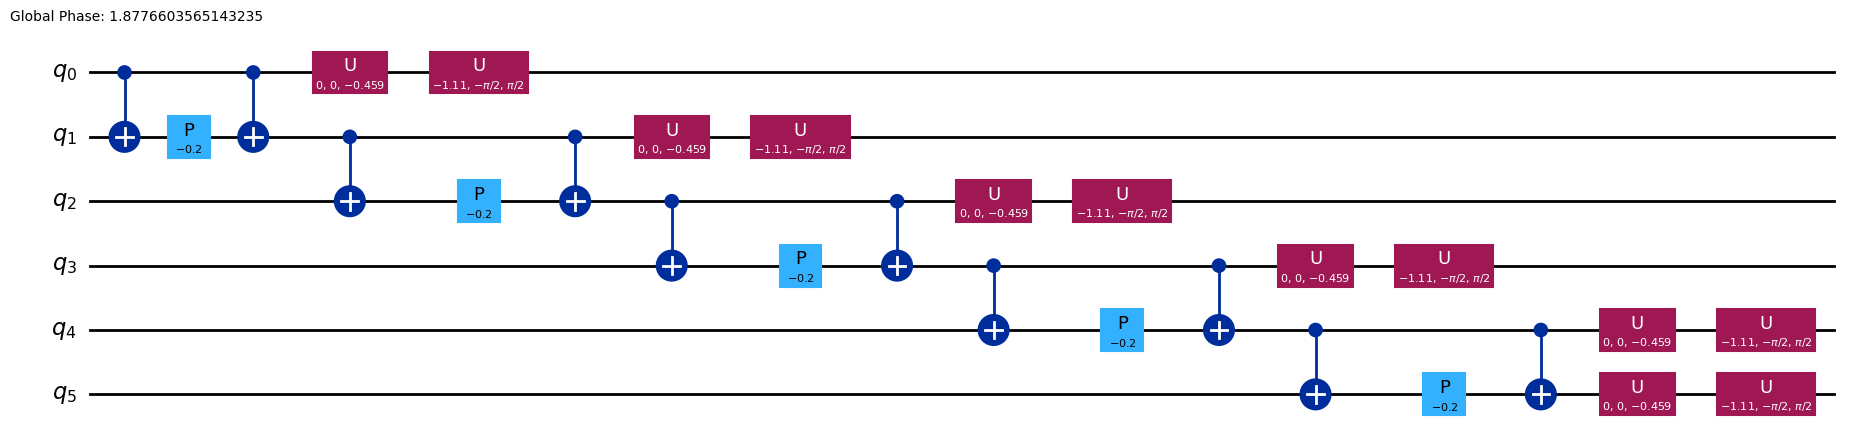

In [7]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(
    single_step_evolution_gates_lt, single_step_evolution_lt.qubits
)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

### 2.5 測定のための演算子の設定

磁化演算子を$\sum_i \langle Z_i \rangle / N$、平均スピン相関演算子を$\sum_i \langle Z_i Z_{i+1} \rangle/ (N - 1)$として定義します。

In [8]:
magnetization = (
    SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n_qubits)], num_qubits=n_qubits
    )
    / n_qubits
)
correlation = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, n_qubits - 1)], num_qubits=n_qubits
) / (n_qubits - 1)
print("magnetization : ", magnetization)
print("correlation : ", correlation)

magnetization :  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])
correlation :  SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


### 2.6 時間発展シミュレーションの実行

エネルギー（ハミルトニアンの期待値）、磁化（磁化演算子の期待値）、平均スピン相関（平均スピン相関演算子の期待値）をモニタリングしましょう。

Qiskitの`StatevectorEstimator` (EstimatorV2)プリミティブは、オブザーバブルの期待値$\langle\psi\vert\hat{O}\vert\psi\rangle$を推定することができます。


In [9]:
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list = []
mag_list = []
corr_list = []
# Estimate expectation values for t=0.0
job = estimator.run(
    [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
)
# Get estimated expectation values
evs = job.result()[0].data.evs
energy_list.append(evs[0])
mag_list.append(evs[1])
corr_list.append(evs[2])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_lt, evolved_state.qubits)
    # Estimate expectation values at delta-t
    job = estimator.run(
        [(evolved_state, [hamiltonian, magnetization, correlation])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    energy_list.append(evs[0])
    mag_list.append(evs[1])
    corr_list.append(evs[2])
# Transform the list of expectation values (at each time step) to arrays
energy_array = np.array(energy_list)
mag_array = np.array(mag_list)
corr_array = np.array(corr_list)

### 2.7 オブザーバブルの時間発展をプロットする

各時間において測定したオブザーバブルの期待値をプロットしましょう。



Text(0.5, 0.98, 'Observable evolution')

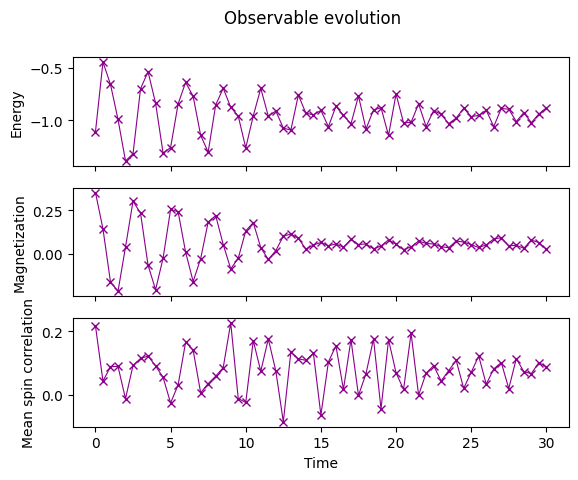

In [10]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times,
    energy_array,
    label="First order",
    marker="x",
    c="darkmagenta",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times, mag_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, corr_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

## 3. エクササイズ 1. 2次鈴木・トロッター分解によるシミュレーション

上記したリー・トロッター分解に続いて、2次鈴木・トロッター分解によるシミュレーションを試してみましょう。

Qiskitにおける2次鈴木・トロッター分解は、[SuzukiTrotter class](/docs/api/qiskit/qiskit.synthesis.SuzukiTrotter)で実装されています。この方法における2次の分解は、：

$$
e^{H_1+H_2} \approx e^{H_1/2}e^{H_2}e^{H_1/2}
$$



### 3.1 1時間ステップの量子回路の実装

product\_formula\_st2 (SuzukiTrotter(order=2))を使い、2次鈴木・トロッター分解を用いて1時間ステップの回路を作成しましょう。また、リー・トロッター分解と比較して量子回路のゲート数と深さを数えましょう。


Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: 34
Gate count: 53
Nonlocal gate count: 20
Gate breakdown: U: 23, CX: 20, P: 10



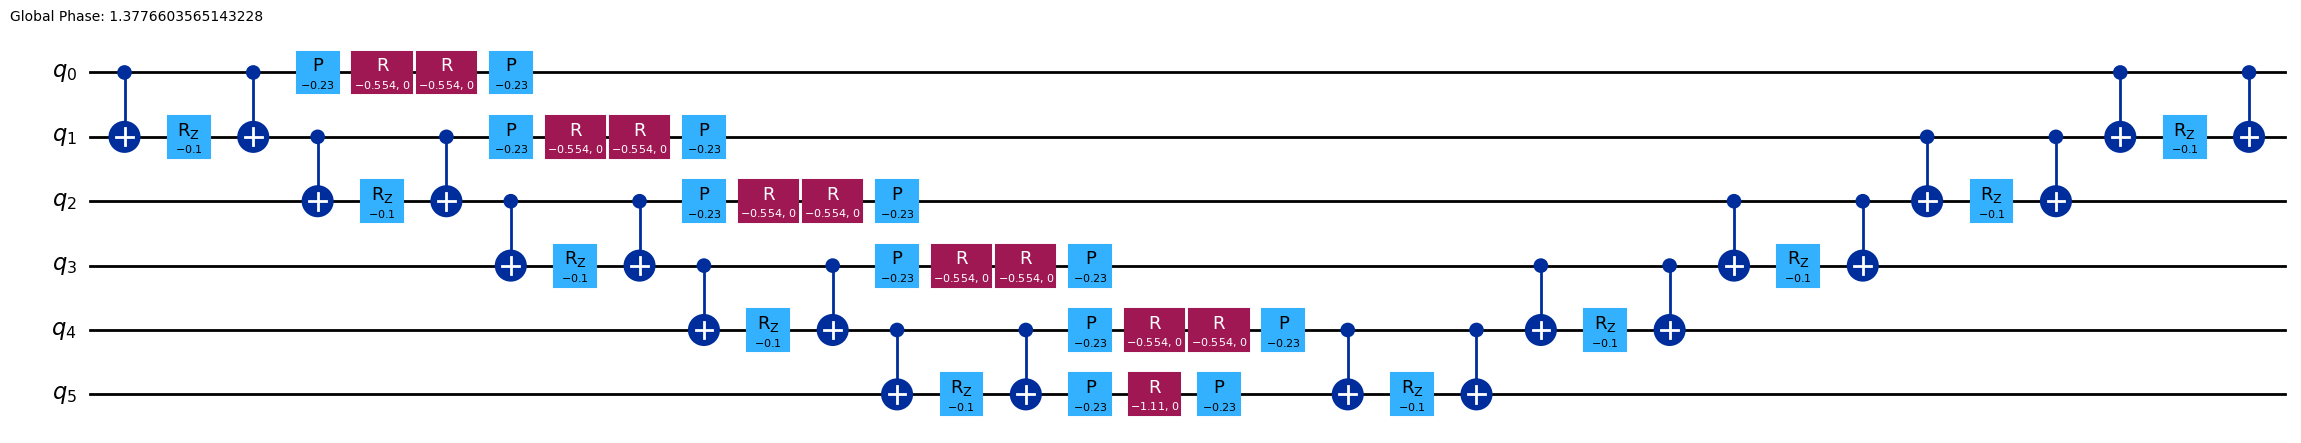

In [11]:
# Modify the line below (Use PauliEvolutionGate)
single_step_evolution_gates_st2 = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_st2
)
single_step_evolution_st2 = QuantumCircuit(n_qubits)
single_step_evolution_st2.append(
    single_step_evolution_gates_st2, single_step_evolution_st2.qubits
)
# Let us print some stats
print(
    f"""
Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: {single_step_evolution_st2.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_st2.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_st2.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_st2.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_st2.decompose(reps=2).draw("mpl", fold=-1)

### 3.2 時間発展シミュレーションの実行

2次鈴木・トロッター分解による時間発展シミュレーションを実行します。

In [12]:
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list_st2 = []
mag_list_st2 = []
corr_list_st2 = []
# Estimate expectation values for t=0.0
job = estimator.run(
    [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
)
# Get estimated expectation values
evs = job.result()[0].data.evs
energy_list_st2.append(evs[0])
mag_list_st2.append(evs[1])
corr_list_st2.append(evs[2])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_st2, evolved_state.qubits)
    # Estimate expectation values at delta-t
    job = estimator.run(
        [(evolved_state, [hamiltonian, magnetization, correlation])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    energy_list_st2.append(evs[0])
    mag_list_st2.append(evs[1])
    corr_list_st2.append(evs[2])
# Transform the list of expectation values (at each time step) to arrays
energy_array_st2 = np.array(energy_list_st2)
mag_array_st2 = np.array(mag_list_st2)
corr_array_st2 = np.array(corr_list_st2)

### 3.3 結果のプロット

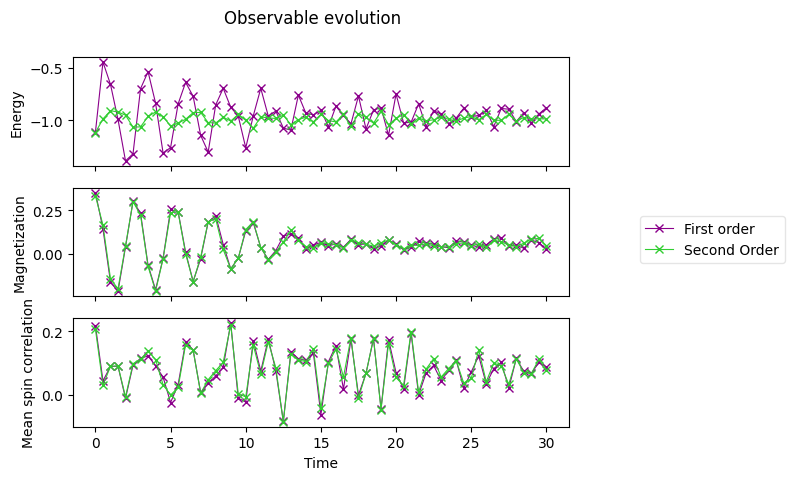

In [13]:
axes[0].plot(
    times,
    energy_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times,
    mag_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[2].plot(
    times,
    corr_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)

# Replace the legend
# legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

### 3.4 解析解との比較

以下のデータは、古典コンピュータで計算された解析解です。

In [14]:
exact_times = np.array(
    [
        0.0,
        0.3,
        0.6,
        0.8999999999999999,
        1.2,
        1.5,
        1.7999999999999998,
        2.1,
        2.4,
        2.6999999999999997,
        3.0,
        3.3,
        3.5999999999999996,
        3.9,
        4.2,
        4.5,
        4.8,
        5.1,
        5.3999999999999995,
        5.7,
        6.0,
        6.3,
        6.6,
        6.8999999999999995,
        7.199999999999999,
        7.5,
        7.8,
        8.1,
        8.4,
        8.7,
        9.0,
        9.299999999999999,
        9.6,
        9.9,
        10.2,
        10.5,
        10.799999999999999,
        11.1,
        11.4,
        11.7,
        12.0,
        12.299999999999999,
        12.6,
        12.9,
        13.2,
        13.5,
        13.799999999999999,
        14.1,
        14.399999999999999,
        14.7,
        15.0,
        15.299999999999999,
        15.6,
        15.899999999999999,
        16.2,
        16.5,
        16.8,
        17.099999999999998,
        17.4,
        17.7,
        18.0,
        18.3,
        18.599999999999998,
        18.9,
        19.2,
        19.5,
        19.8,
        20.099999999999998,
        20.4,
        20.7,
        21.0,
        21.3,
        21.599999999999998,
        21.9,
        22.2,
        22.5,
        22.8,
        23.099999999999998,
        23.4,
        23.7,
        24.0,
        24.3,
        24.599999999999998,
        24.9,
        25.2,
        25.5,
        25.8,
        26.099999999999998,
        26.4,
        26.7,
        27.0,
        27.3,
        27.599999999999998,
        27.9,
        28.2,
        28.5,
        28.799999999999997,
        29.099999999999998,
        29.4,
        29.7,
        30.0,
    ]
)
exact_energy = np.array(
    [
        -1.1184402376762155,
        -1.1184402376762157,
        -1.1184402376762157,
        -1.1184402376762148,
        -1.1184402376762153,
        -1.1184402376762155,
        -1.1184402376762148,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762153,
        -1.1184402376762148,
        -1.118440237676217,
        -1.118440237676215,
        -1.1184402376762161,
        -1.1184402376762157,
        -1.118440237676217,
        -1.1184402376762161,
        -1.1184402376762137,
        -1.1184402376762161,
        -1.1184402376762161,
        -1.118440237676218,
        -1.1184402376762155,
        -1.1184402376762166,
        -1.1184402376762155,
        -1.1184402376762137,
        -1.1184402376762186,
        -1.1184402376762215,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.1184402376762121,
        -1.1184402376762166,
        -1.1184402376762181,
        -1.1184402376762137,
        -1.1184402376762148,
        -1.1184402376762193,
        -1.1184402376762108,
        -1.1184402376762144,
        -1.118440237676217,
        -1.1184402376762197,
        -1.1184402376762153,
        -1.1184402376762161,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676214,
        -1.118440237676214,
        -1.1184402376762161,
        -1.118440237676212,
        -1.1184402376762164,
        -1.118440237676217,
        -1.1184402376762121,
        -1.1184402376762157,
        -1.1184402376762212,
        -1.1184402376762217,
        -1.1184402376762206,
        -1.118440237676222,
        -1.1184402376762166,
        -1.118440237676212,
        -1.1184402376762137,
        -1.11844023767622,
        -1.1184402376762206,
        -1.118440237676219,
        -1.1184402376762153,
        -1.1184402376762164,
        -1.118440237676209,
        -1.1184402376762144,
        -1.1184402376762161,
        -1.118440237676216,
        -1.1184402376762173,
        -1.118440237676214,
        -1.1184402376762093,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676213,
        -1.1184402376762195,
        -1.1184402376762095,
        -1.1184402376762075,
        -1.1184402376762197,
        -1.1184402376762141,
        -1.1184402376762146,
        -1.1184402376762184,
        -1.118440237676218,
        -1.1184402376762224,
        -1.118440237676219,
        -1.118440237676218,
        -1.1184402376762206,
        -1.1184402376762168,
        -1.118440237676221,
        -1.118440237676218,
        -1.1184402376762148,
        -1.1184402376762106,
        -1.1184402376762173,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762113,
        -1.1184402376762275,
        -1.1184402376762195,
    ]
)
exact_magnetization = np.array(
    [
        0.3333333333333333,
        0.26316769633415005,
        0.0912947227110664,
        -0.09317712543141576,
        -0.20391854332115245,
        -0.19318196655046493,
        -0.06411527074401464,
        0.12558269854206197,
        0.28252754464640606,
        0.3264196194042506,
        0.2361586169847769,
        0.060894367906122224,
        -0.10842387093076275,
        -0.18636359582538073,
        -0.1338364343947887,
        0.020284606520827753,
        0.19151142743926025,
        0.2905341647678381,
        0.2723014646745304,
        0.15147481733047252,
        -0.008179102877790292,
        -0.1242999208732406,
        -0.1372529247781061,
        -0.04083616185958952,
        0.11066094926716476,
        0.23140661570567636,
        0.2587109403786205,
        0.1868237670027325,
        0.061201779383143744,
        -0.051391248969654205,
        -0.09843899603365061,
        -0.061297056158849166,
        0.04199010081939773,
        0.15861461430963147,
        0.22336830674799552,
        0.20179555623336537,
        0.11407111438609417,
        0.01609419104778282,
        -0.04239611796730001,
        -0.04249123521065924,
        0.008850291714888112,
        0.08780898151558082,
        0.1561486776507056,
        0.17627348772811832,
        0.13870676179652253,
        0.07205869195282538,
        0.018300003064909465,
        0.0001095640839572417,
        0.015157929316037586,
        0.05077755280969454,
        0.09245534457650838,
        0.12206907551110702,
        0.12284950557969157,
        0.09570215398601932,
        0.06294378255078983,
        0.045503313813986014,
        0.043389819499542556,
        0.046725117769796744,
        0.054956411358382404,
        0.0713814528253614,
        0.08743689703248492,
        0.08951216359166674,
        0.07878386475305985,
        0.06955669116405788,
        0.06639892435963689,
        0.05890378761746903,
        0.04541796525844558,
        0.0414221088331947,
        0.05499634106912299,
        0.07409418836014572,
        0.08371859070160165,
        0.08211623987959302,
        0.07615055161378328,
        0.06702584458783024,
        0.051891407742740085,
        0.038049378383635625,
        0.03825614149768043,
        0.054183218463525695,
        0.0753534475741016,
        0.08853147112587295,
        0.08767917178542013,
        0.07709383184439536,
        0.06308595032042386,
        0.0498812359204284,
        0.04299040064096167,
        0.04769159891460652,
        0.06483569572288776,
        0.08698035745435016,
        0.10047391641776235,
        0.09747255683203637,
        0.08098863187287358,
        0.05959496723987331,
        0.04383882265040485,
        0.04232138798062125,
        0.05720514169944535,
        0.08201306299870219,
        0.10274898262000469,
        0.10707552455080133,
        0.09210856128265357,
        0.06379922105742579,
        0.03624325103307953,
    ]
)
exact_correlation = np.array(
    [
        0.2,
        0.1247704225763532,
        0.01943938494098705,
        0.03854917181332821,
        0.11196616231067426,
        0.0906546700356683,
        0.01629373561896267,
        0.011352652889791095,
        0.0636185676540077,
        0.09543834437789013,
        0.10058518161011307,
        0.11829217731417431,
        0.1397812224038133,
        0.12316460402216707,
        0.08541383059335775,
        0.06144846844403662,
        0.020246372880505827,
        -0.02693683090021662,
        0.003919250903281282,
        0.1117419430168554,
        0.19676155181256794,
        0.18594408880783336,
        0.1002673802566004,
        0.03821525827438024,
        0.04485205090247377,
        0.05348102743040269,
        0.03160026140008638,
        0.033437649060464834,
        0.10486939975320728,
        0.20249469538955758,
        0.19735507621013149,
        0.0553097261765083,
        -0.04889114490131667,
        0.011685690974970964,
        0.11705971535823065,
        0.11681165998194759,
        0.06637091239560744,
        0.10936684225958895,
        0.20225454101061405,
        0.16284420833341812,
        -0.0025823294931362067,
        -0.0763416631752919,
        0.02985268630418397,
        0.15234468006771007,
        0.14606385406970995,
        0.0935341856492092,
        0.12325421854361143,
        0.17130422930386324,
        0.10383730044042278,
        -0.031333159406547614,
        -0.05241572078596815,
        0.07722509925347705,
        0.17642188574256007,
        0.12765340239966838,
        0.06309968945093776,
        0.11574687130499339,
        0.16978282647206913,
        0.0736143632571229,
        -0.05356602733119409,
        -0.0009649396796768892,
        0.15921620111869142,
        0.17760366431811037,
        0.04736297330213485,
        0.012122870263181897,
        0.13268065586830521,
        0.1728473023503636,
        0.03999259331072221,
        -0.036997053070222885,
        0.06951528580242439,
        0.1769169993516561,
        0.12290448295710298,
        0.012897784654866427,
        0.02859435620982225,
        0.12895847695150875,
        0.13629536955485938,
        0.05394621059822597,
        0.02298040588184324,
        0.07036499900317271,
        0.11706448623132719,
        0.10435285842074606,
        0.055721236329964965,
        0.04676334743672697,
        0.08417924910022263,
        0.10611161955304965,
        0.089304171047322,
        0.06098589533081194,
        0.06314519797488709,
        0.09431492621892917,
        0.09667836915967139,
        0.0651298357290882,
        0.05176966009147416,
        0.06727229484222669,
        0.08871788283607947,
        0.09907054249093444,
        0.09785167773502176,
        0.09277216140054353,
        0.07520999642062785,
        0.05894392248382922,
        0.07236135251622376,
        0.08608284185200156,
        0.07282922961856123,
    ]
)

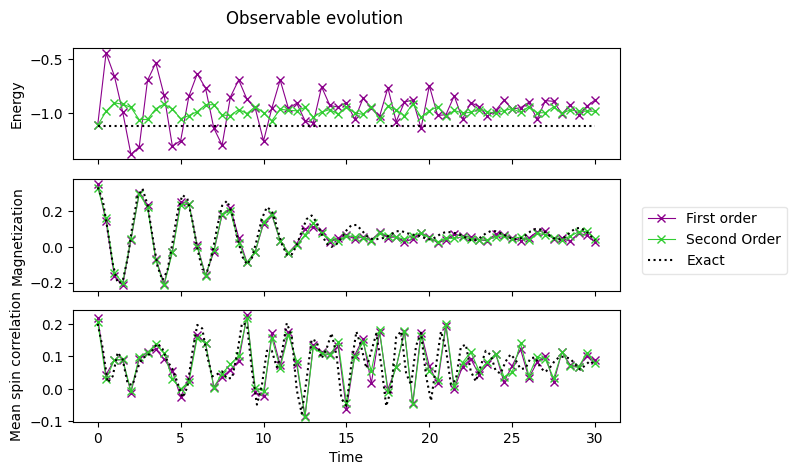

In [15]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Replace the legend
legend.remove()
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

## 4. 量子ハードウェアでの実行

次に、時間発展シミュレーションを量子ハードウェア上で実行しましょう。ここではより小さな、格子サイズ$N=2$の問題へ取り組みます。パラメータ$\alpha$を変え、波動関数のダイナミクスの変化を観察しましょう。


### 4.1  ステップ１.量子の問題へマッピング

シミュレーションの初期条件を設定します：

In [16]:
n_qubits_2 = 2
dt_2 = 1.6
product_formula = LieTrotter(reps=1)

初期回路を設定します。

スピンの初期条件は"down-up"とします。：


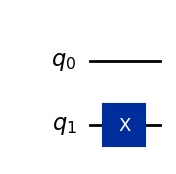

In [17]:
# We prepare an initial state ↓↑ (10).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_circuit_2 = QuantumCircuit(n_qubits_2)
initial_circuit_2.prepare_state("10")
# Change reps and see the difference when you decompose the circuit
initial_circuit_2.decompose(reps=1).draw("mpl")

ここで、理想的な状態ベクトルシミュレータを用いて、参照する値を計算します。


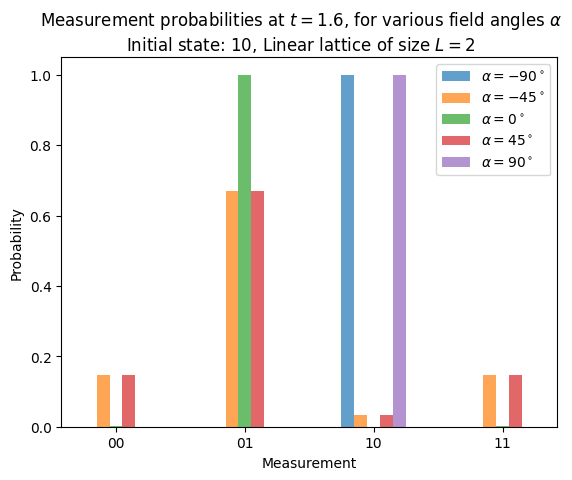

In [18]:
bar_width = 0.1
# initial_state = Statevector.from_label("10")
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    evolved_state_2 = QuantumCircuit(initial_circuit_2.num_qubits)
    evolved_state_2.append(initial_circuit_2, evolved_state_2.qubits)
    hamiltonian_2 = get_hamiltonian(nqubits=2, J=0.2, h=1.0, alpha=alpha)
    single_step_evolution_gates_2 = PauliEvolutionGate(
        hamiltonian_2, dt_2, synthesis=product_formula
    )
    evolved_state_2.append(single_step_evolution_gates_2, evolved_state_2.qubits)
    evolved_state_2 = Statevector(evolved_state_2)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state_2.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

量子系の初期状態をスピン$\downarrow\uparrow$で初期化しました。これは量子状態$\vert\psi(0)\rangle = \vert10\rangle$に対応します。$\alpha=0^\circ$の横向き場で$t=1.6$まで時間発展したあと、ほとんど$\uparrow\downarrow$が測定できることを示しました。つまり、スピンの交換です（ラベルは右から左に読むことに注意してください）。もし場が縦向き($\alpha=\pm90^\circ$)のとき、なんの時間発展もなく、初期状態で設定した$\downarrow\uparrow$が常に測定されます。中間の角度（$\alpha=\pm45^\circ$）では、あらゆる組み合わせを異なる確率で測定することができ、スピンの交換はおよそ確率0.67で得ることができます。


#### ハードウェア実験のための量子回路の構成



In [19]:
circuit_list = []
for i, alpha in enumerate(alphas):
    evolved_state_2 = QuantumCircuit(initial_circuit_2.num_qubits)
    evolved_state_2.append(initial_circuit_2, evolved_state_2.qubits)
    hamiltonian_2 = get_hamiltonian(nqubits=2, J=0.2, h=1.0, alpha=alpha)
    single_step_evolution_gates_2 = PauliEvolutionGate(
        hamiltonian_2, dt_2, synthesis=product_formula
    )
    evolved_state_2.append(single_step_evolution_gates_2, evolved_state_2.qubits)
    evolved_state_2.measure_all()
    circuit_list.append(evolved_state_2)

### 4.2 ステップ２. ターゲットのハードウェア向けに回路を最適化

バックエンドを識別します。

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

選択されたバックエンドに向けてトランスパイルします。


In [22]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
circuit_isa = pm.run(circuit_list)

回路を確認します。



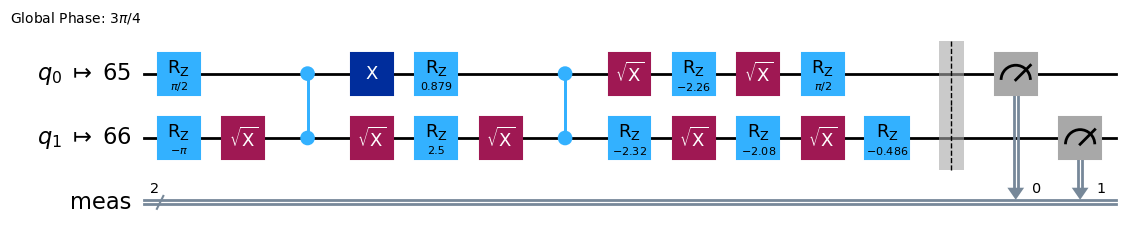

In [23]:
circuit_isa[1].draw("mpl", idle_wires=False)

### 4.3 ステップ３. Qiskit Runtimeプリミティブを用いて実行

Qiskitの`Sampler` (V2)プリミティブは、測定されたビット列の個数を提供します。

In [24]:
sampler = SamplerV2(mode=backend)
job = sampler.run(circuit_isa)
job_id = job.job_id()
print("job id:", job_id)

job id: d27fb4boctts738j8d20


結果を保存します。

In [26]:
results = job.result()

### 4.4 ステップ４. 結果の後処理

ビット列のヒストグラムを構築します。これは波動関数の解析に由来します。そして、これらを上で確認した理想の解と比較しましょう。

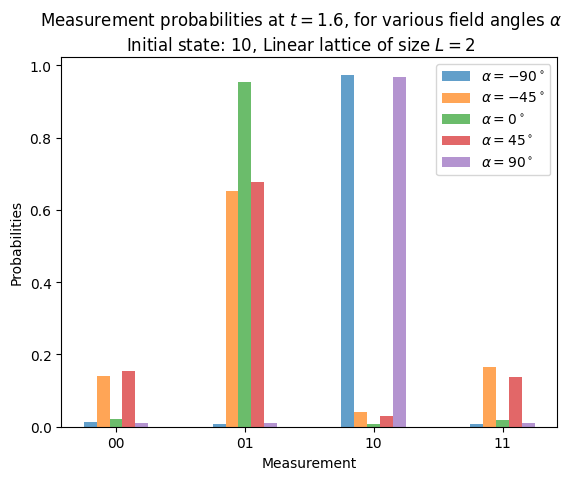

In [27]:
list_temp = ["00", "01", "10", "11"]

for i, alpha in enumerate(alphas):
    # Dictionary of probabilities
    amplitudes_dict = results[i].data.meas.get_counts()
    values = []
    for str_temp in list_temp:
        values.append(
            amplitudes_dict[str_temp] / 4096.0
        )  # divided by default number of shots
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probabilities")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

ここでは4次鈴木・トロッター分解の回路を構築した例を示します。

上の例にしたがって、4次鈴木・トロッター分解の回路を構築しましょう。

4次鈴木・トロッター分解は、[SuzukiTrotter class](/docs/api/qiskit/qiskit.synthesis.SuzukiTrotter)を用いて実装できます。4次は以下に示すような再帰関係で評価できます。鈴木・トロッター分解の次数は、以下の式では"2k"と書かれていることに注意してください。

$$
\hat{U}_{ST(2k)}\left(t\right) = \left[ \hat{U}_{ST(2k-2)}\left(p_k t\right) \right]^2 \hat{U}_{ST(2k-2)}\left( (1- 4 p_k) t\right)\left[ \hat{U}_{ST(2k-2)}\left(p_k t\right) \right]^2
$$

$$
p_k = 1 / \left(4-4^{\frac{1}{2k-1}}\right)
$$


#### 1時間ステップの回路の構築

product\_formula\_st4 (SuzukiTrotter(order=4))を用いて、4次鈴木・トロッター分解の1時間ステップ回路を構築しましょう。また、ゲート数と深さをカウントし、リー・トロッター分解や2次鈴木・トロッター分解の結果と比較しましょう。



Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: 170
Gate count: 265
Nonlocal gate count: 100
Gate breakdown: U: 115, CX: 100, P: 50



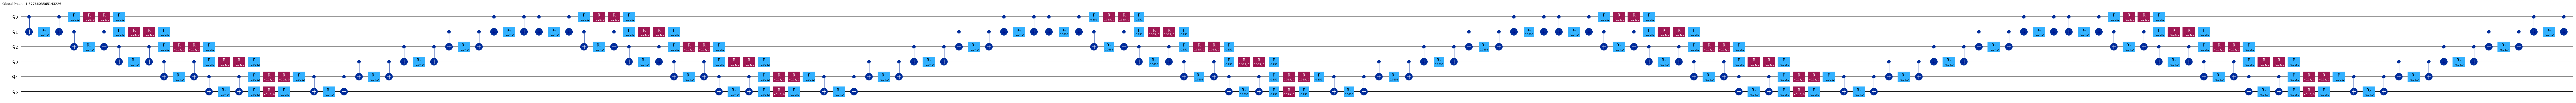

In [28]:
# Modify the line below (Use PauliEvolutionGate)
single_step_evolution_gates_st4 = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_st4
)
single_step_evolution_st4 = QuantumCircuit(n_qubits)
single_step_evolution_st4.append(
    single_step_evolution_gates_st4, single_step_evolution_st4.qubits
)
# Let us print some stats
print(
    f"""
Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: {single_step_evolution_st4.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_st4.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_st4.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_st4.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_st4.decompose(reps=2).draw("mpl", fold=-1)

In [29]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.1.0'

© IBM Corp., 2017-2025